In [91]:
import os
import sys

# os.chdir('../')
sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from multipy.fwer import sidak, hochberg
import random
import logomaker

import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)
from source.alpha_beta_paired_clones_search import plot_cooccured_epitopes_table
from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, \
                            plot_clonotype_clustering_with_epitope_labeling, plot_cooccurence_heatmap_with_epitopes_labeling_bubble, \
                            plot_volcano, create_epitope_name
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column, prepare_clonotype_matrix
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing, get_top_changed_clonotypes
from utils.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster, get_most_frequent_cluster_by_vdjdb_occurence, \
                                    create_summary_stats_table
from utils.weblogo_utils import create_web_logo
from math import sqrt


import warnings
warnings.filterwarnings('ignore')

In [2]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

In [3]:
um = pd.read_csv('data/standardized_usage_matrix_fmba_TRB.csv').drop(columns=['Unnamed: 0'])

In [4]:
train_runs = prepare_run_column(um[~um.is_test_run]).run
test_runs = prepare_run_column(um[um.is_test_run]).run

In [5]:
desc = pd.read_csv('data/desc_fmba_not_nan_hla.csv').drop(columns=['Unnamed: 0']).merge(um[['run', 'is_test_run']])
desc['covid'] = desc.COVID_status.apply(lambda x: 'covid' if x == 'COVID' else 'healthy')
desc

,run,reads,clonotypes,singletons,doubletons,file.id,sequencingDate,folder,R1,R2,...,HLA-DRB1.2,id,subsequent_sequencing,HLA-DRB4.1,HLA-DRB3.1,HLA-DRB5.1,gene,is.bad.reseq,is_test_run,covid
0,020000010808_S3_L001.clonotypes.TRB.txt,623811,4324,491,263,020000010808_S3_L001,2020 10 19,2020/10_FMBA_NovaSeq5,020000010808_S3_L001_R1_001.fastq.gz,020000010808_S3_L001_R2_001.fastq.gz,...,DRB1*16:01,20000010,NaN,NaN,NaN,NaN,TRB,NaN,False,covid
1,020000110808_S14_L001.clonotypes.TRB.txt,13119545,13264,573,219,020000110808_S14_L001,2020 09 05,2020/09_FMBA_NovaSeq_DNA,020000110808_S14_L001_R1_001.fastq.gz,020000110808_S14_L001_R2_001.fastq.gz,...,DRB1*15:01,20000110,NaN,NaN,NaN,NaN,TRB,NaN,False,covid
2,020000190808_S27_L001.clonotypes.TRB.txt,6942203,16977,1198,550,020000190808_S27_L001,2020 10 19,2020/10_FMBA_NovaSeq5,020000190808_S27_L001_R1_001.fastq.gz,020000190808_S27_L001_R2_001.fastq.gz,...,DRB1*15:02,20000190,NaN,NaN,NaN,NaN,TRB,NaN,False,covid
3,020000200808_S181_L002.clonotypes.TRB.txt,6583555,14220,916,420,020000200808_S181_L002,2020 10 19,2020/10_FMBA_NovaSeq5,020000200808_S181_L002_R1_001.fastq.gz,020000200808_S181_L002_R2_001.fastq.gz,...,DRB1*04:04,20000200,NaN,NaN,NaN,NaN,TRB,NaN,False,healthy
4,020000280808_S59_L001.clonotypes.TRB.txt,2005779,6144,477,260,020000280808_S59_L001,2020 10 19,2020/10_FMBA_NovaSeq5,020000280808_S59_L001_R1_001.fastq.gz,020000280808_S59_L001_R2_001.fastq.gz,...,DRB1*13:03,20000280,NaN,NaN,NaN,NaN,TRB,NaN,False,covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,780008510808_S152_L002.clonotypes.TRB.txt,125864,7215,1173,793,780008510808_S152_L002,2020 09 27,2020/09_FMBA_NovaSeq3_DNA,780008510808_S152_L002_R1_001.fastq.gz,780008510808_S152_L002_R2_001.fastq.gz,...,DRB1*15:01,780008510,NaN,NaN,NaN,NaN,TRB,NaN,False,covid
952,780008550808_S150_L002.clonotypes.TRB.txt,3070841,8864,398,150,780008550808_S150_L002,2020 09 27,2020/09_FMBA_NovaSeq3_DNA,780008550808_S150_L002_R1_001.fastq.gz,780008550808_S150_L002_R2_001.fastq.gz,...,DRB1*15:01,780008550,NaN,NaN,NaN,NaN,TRB,NaN,False,covid
953,910000140808_S123_L002.clonotypes.TRB.txt,3095012,27443,1318,643,910000140808_S123_L002,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,910000140808_S123_L002_R1_001.fastq.gz,910000140808_S123_L002_R2_001.fastq.gz,...,DRB1*07:01,910000140,NaN,NaN,NaN,NaN,TRB,NaN,False,covid
954,910000320808_S121_L002.clonotypes.TRB.txt,203560,11451,2013,1299,910000320808_S121_L002,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,910000320808_S121_L002_R1_001.fastq.gz,910000320808_S121_L002_R2_001.fastq.gz,...,DRB1*07:01,910000320,NaN,NaN,NaN,NaN,TRB,NaN,False,covid


In [6]:
desc.COVID_status.value_counts()

COVID      661
healthy    295
Name: COVID_status, dtype: int64

# β chain biomarkers postprocessing

In [7]:
os.getcwd()

'/home/evlasova/tcr-covid-classifier'

In [8]:
raw_beta_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_top_500k.csv').drop(columns=['Unnamed: 0'])

In [9]:
raw_beta_cm

,CAGSLGGSYEQYF,CANSLGGSYEQYF,CASARGYEQYF,CASDRGYEQYF,CASGLGGNQPQHF,CASGLGGSYEQYF,CASGLSGGNQPQHF,CASMRGYEQYF,CASNLGGSYEQYF,CASRDAYEQYF,...,CSARSSYEQYF,CSARTSYEQYF,CSASDRGYEQYF,CSASDSYEQYF,CSASGGGYEQYF,CSASSGHEQYF,CSATDLNTEAFF,CSATSGHEQYF,GASSLSGGNQPQHF,run
0,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,2,020000010808_S3_L001.clonotypes.TRB.txt
1,6,4,0,1,0,3,0,0,3,0,...,0,0,0,3,0,0,0,0,0,020000420808_S51_L001.clonotypes.TRB.txt
2,1,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,050000200808_S157_L002.clonotypes.TRB.txt
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,020003810808_S104_L002.clonotypes.TRB.txt
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,270000110808_S166_L002.clonotypes.TRB.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,640001980808_S85_L001.clonotypes.TRB.txt
952,0,0,0,0,2,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,550002620808_S172_L002.clonotypes.TRB.txt
953,0,0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,640003580808_S34_L001.clonotypes.TRB.txt
954,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,640002920808_S23_L001.clonotypes.TRB.txt


In [10]:
clean_beta_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_leaks.csv').drop(columns=['Unnamed: 0'])

In [11]:
clean_beta_cm

,run,CANSLGGSYEQYF,CASARGYEQYF,CASDRGYEQYF,CASGLGGNQPQHF,CASGLGGSYEQYF,CASGLSGGNQPQHF,CASMRGYEQYF,CASNLGGSYEQYF,CASRDAYEQYF,...,CSARKSYEQYF,CSARSGHEQYF,CSARSSYEQYF,CSARTSYEQYF,CSASDRGYEQYF,CSASDSYEQYF,CSASGGGYEQYF,CSASSGHEQYF,CSATDLNTEAFF,CSATSGHEQYF
0,020000010808_S3_L001,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,020000420808_S51_L001,4,0,1,0,3,0,0,3,0,...,0,0,0,0,0,3,0,0,0,0
2,050000200808_S157_L002,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,020003810808_S104_L002,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,270000110808_S166_L002,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,640001980808_S85_L001,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
952,550002620808_S172_L002,0,0,0,2,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
953,640003580808_S34_L001,0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
954,640002920808_S23_L001,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


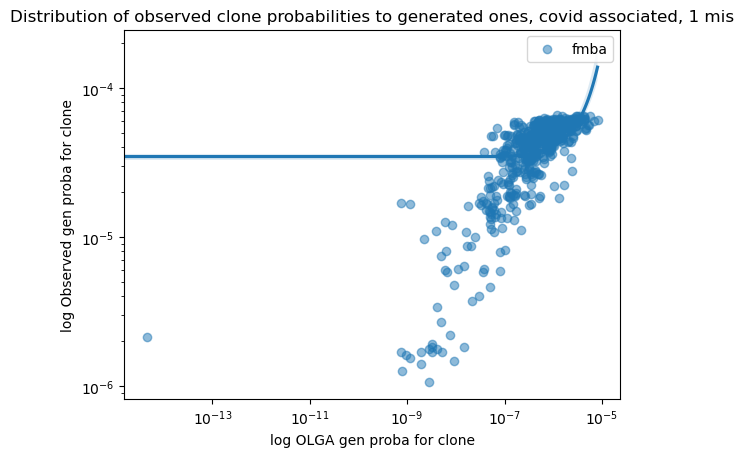

In [12]:
probas_beta = plot_generated_to_real_distribution(pgen_paths=['data/covid_fmba_TRB_pgen.csv'], 
                                    cm_paths=['data/significant_clone_matrix_fisher_fmba_TRB_top_500k.csv'], 
                                    desc='covid associated, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv', 
                                    labels=['fmba'])['fmba']

In [13]:
covid_clones_beta = clean_beta_cm.columns[1:]
res_beta = seqs2hamming(covid_clones_beta, viz_method='graphopt')

In [14]:
res_beta

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CANSLGGSYEQYF,0,70.801691,-65.180404,182,121.256090,61.794463
1,CASSLGGSYEQYF,0,78.578640,39.095082,182,121.256090,61.794463
2,CASGLGGSYEQYF,0,89.599239,-51.788293,182,121.256090,61.794463
3,CASNLGGSYEQYF,0,106.062364,-50.405077,182,121.256090,61.794463
4,CASRPGGSYEQYF,0,-4.622189,85.748606,182,121.256090,61.794463
...,...,...,...,...,...,...,...
525,CSARTSYEQYF,54,491.355508,-250.969721,5,494.359114,-265.879995
526,CSASDRGYEQYF,55,-120.443406,-256.592797,1,-120.443406,-256.592797
527,CSASDSYEQYF,56,396.275895,-506.880862,1,396.275895,-506.880862
528,CSASGGGYEQYF,57,-259.398852,-429.777125,1,-259.398852,-429.777125


In [61]:
beta_clusters_list = list(res_beta[['cluster', 'cluster_size']].drop_duplicates().sort_values(by='cluster_size', ascending=False).cluster)

In [15]:
beta_cluster_to_epi = {}
for cluster_index in range(res_beta.cluster.max()+1):
    beta_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_beta, cluster_index, dist=1, gene='TRB', alpha=0.05)

# α chain biomarkers postprocessing

In [16]:
clean_alpha_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRA_top_500k_wo_leaks.csv').drop(columns=['Unnamed: 0'])

In [17]:
raw_alpha_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRA_top_500k.csv').drop(columns=['Unnamed: 0'])

In [18]:
clean_alpha_cm

,run,CAAADNFNKFYF,CAAAFNKFYF,CAAAGNNRKLIW,CAAALYNFNKFYF,CAAANFNKFYF,CAAANNFNKFYF,CAAAPYNFNKFYF,CAAARYNFNKFYF,CAAATQGGSEKLVF,...,CVVTIYNFNKFYF,CVVTLYNFNKFYF,CVVTNFNKFYF,CVVTYNFNKFYF,CVVVNFNKFYF,CVVVYNFNKFYF,CVVYLYNFNKFYF,CVVYNFNKFYF,CVYNFNKFYF,YALSSGSARQLTF
0,020000010808_S3_L001,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,050000200808_S157_L002,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,020003810808_S104_L002,0,0,1,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,020000420808_S51_L001,0,0,1,0,0,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
4,270000870808_S37_L001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,550003260808_S186_L002,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
952,640002910808_S86_L001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
953,640001980808_S85_L001,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
954,210002850808_S120_L002,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2


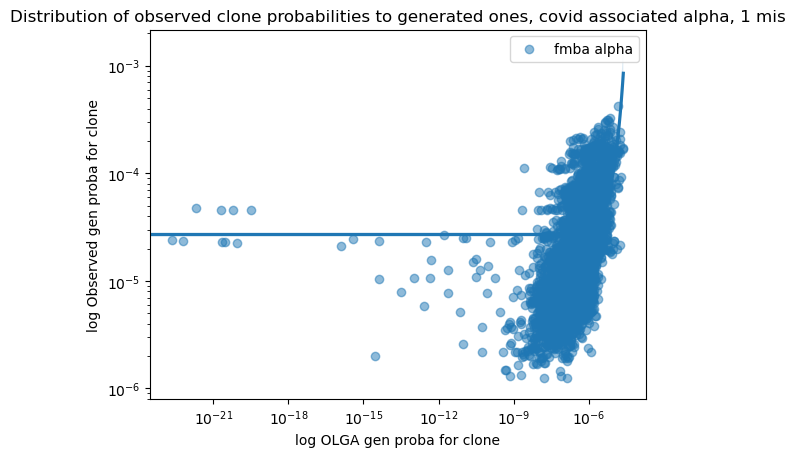

In [19]:
probas_alpha = plot_generated_to_real_distribution(pgen_paths=['data/covid_fmba_TRA_pgen.csv'], 
                                    cm_paths=['data/significant_clone_matrix_fisher_fmba_TRA_top_500k.csv'], 
                                    desc='covid associated alpha, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv', 
                                    labels=['fmba alpha'],
                                    make_bool_features=False)['fmba alpha']

In [20]:
covid_clones_alpha = clean_alpha_cm.columns[1:]
res_alpha = seqs2hamming(covid_clones_alpha, viz_method='drl')

In [21]:
res_alpha

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CAAADNFNKFYF,0,-2.388528,93.963020,793,52.189541,79.166327
1,CAAANNFNKFYF,0,8.361341,136.302048,793,52.189541,79.166327
2,CAAAYNFNKFYF,0,62.324902,17.681643,793,52.189541,79.166327
3,CAAEDNFNKFYF,0,-2.722980,93.541504,793,52.189541,79.166327
4,CAAGDNFNKFYF,0,-7.097733,88.760498,793,52.189541,79.166327
...,...,...,...,...,...,...,...
4054,CVVSDLMEYGNKLVF,135,-48.651840,415.369537,1,-48.651840,415.369537
4055,CVVSELSGGYQKVTF,136,39.410271,345.894653,2,39.458530,346.155518
4056,CVVSEPSGGYQKVTF,136,39.506790,346.416382,2,39.458530,346.155518
4057,CVVSGTGFQKLVF,137,405.736725,-71.420898,1,405.736725,-71.420898


In [62]:
alpha_clusters_list = list(res_alpha[['cluster', 'cluster_size']].drop_duplicates().sort_values(by='cluster_size', ascending=False).cluster)

In [22]:
alpha_cluster_to_epi = {}
for cluster_index in range(res_alpha.cluster.max()+1):
    alpha_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_alpha, cluster_index, dist=1, gene='TRA')

In [23]:
alpha_cluster_to_epi[0]

,antigen.epitope,antigen.species,count
7,GLMWLSYFI,SARS-CoV-2,4
4,FTSDYYQLY,SARS-CoV-2,16
11,MFLARGIVF,SARS-CoV-2,27
13,NQKLIANQF,SARS-CoV-2,31
18,SGPLKAEIAQRLED,InfluenzaA,33
20,VPYFNMVYM,SARS-CoV-2,50
10,LLWNGPMAV,YFV,53


# α, β co-occorence analysis

In [24]:
cooccurence_dist1_epitopes = [[set() for _ in range(res_alpha.cluster.max() + 1)] for _ in
                                  range(res_beta.cluster.max() + 1)]
for beta_cluster in res_beta.cluster.unique():
    for alpha_cluster in res_alpha.cluster.unique():
        alpha_epi = set(alpha_cluster_to_epi[alpha_cluster]['antigen.epitope']) if alpha_cluster_to_epi[alpha_cluster] is not None else set()
        beta_epi = set(beta_cluster_to_epi[beta_cluster]['antigen.epitope']) if beta_cluster_to_epi[beta_cluster] is not None else set()
        cooccurence_dist1_epitopes[beta_cluster][alpha_cluster] = alpha_epi.intersection(beta_epi)

In [25]:
cooccurence_df = pd.read_csv('data/TRA_TRB_cooccurence_matrix_cooccurence_85.csv').T
annot_df = pd.read_csv('data/alpha_beta_paired_epitopes.csv').T

In [26]:
all_alpha_cm = pd.read_csv('data/clone_matrix_fmba_TRA_top_500k.csv', nrows=50000)
all_alpha_cm = prepare_clonotype_matrix(clonotype_matrix=all_alpha_cm).merge(clean_alpha_cm)
fold_change_data_alpha = get_top_changed_clonotypes(clonotype_matrix=all_alpha_cm.merge(prepare_run_column(desc[~desc.folder.str.contains('NovaSeq7')][['run']])), 
                           desc=desc, 
                           pvals=pd.read_csv('data/covid_significant_clone_pvals_fmba_TRA_top_500k.csv').drop(columns=['Unnamed: 0']), 
                           run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'),
                           healthy_col='COVID_status', 
                           healthy_label='healthy')
fold_change_data_alpha

v


,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
0,AAAGNKLTF,9.294416e-01,0.002375,0.004294,1.808126,0.854495
1,AAGGTSYGKLTF,8.972555e-01,0.016788,0.037033,2.205900,1.141367
2,AAGNKLTF,5.093511e-01,0.000622,0.001433,2.304795,1.204638
3,AAGNMLTF,9.634783e-01,0.002996,0.005397,1.801316,0.849051
4,AAGNNRKLIW,3.004570e-01,0.000920,0.002856,3.104511,1.634366
...,...,...,...,...,...,...
53886,CVVVYNFNKFYF,1.031492e-08,0.001821,0.008502,4.669817,2.223366
53887,CVVYLYNFNKFYF,6.721733e-06,0.001357,0.005797,4.270929,2.094550
53888,CVVYNFNKFYF,1.975430e-16,0.004052,0.017962,4.432400,2.148088
53889,CVYNFNKFYF,6.759089e-09,0.001188,0.006692,5.633724,2.494089


In [27]:
all_beta_cm = pd.read_csv('data/clone_matrix_fmba_TRB_top_500k.csv', nrows=50000)
all_beta_cm = prepare_clonotype_matrix(clonotype_matrix=all_beta_cm).merge(clean_beta_cm)
fold_change_data_beta = get_top_changed_clonotypes(clonotype_matrix=all_beta_cm.merge(prepare_run_column(desc[~desc.folder.str.contains('NovaSeq7')][['run']])), 
                           desc=desc, 
                           pvals=pd.read_csv('data/covid_significant_clone_pvals_fmba_TRB_top_500k.csv').drop(columns=['Unnamed: 0']), 
                           run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'),
                           healthy_col='COVID_status', 
                           healthy_label='healthy')
fold_change_data_beta

v


,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
0,CAAADGTVNSPLHF,4.457863e-01,0.000000,0.000063,inf,inf
1,CAAADYGYTF,4.831917e-01,0.000236,0.000456,1.930784,0.949187
2,CAAAGANVLTF,3.659061e-02,0.000126,0.000768,6.084866,2.605225
3,CAAAGDGNTIYF,4.628932e-01,0.000041,0.000090,2.195235,1.134376
4,CAAAGGDTQYF,8.242857e-01,0.000224,0.000256,1.139224,0.188051
...,...,...,...,...,...,...
50517,CSASDSYEQYF,7.720096e-07,0.001769,0.007350,4.154393,2.054638
50518,CSASGGGYEQYF,4.794402e-07,0.001378,0.006774,4.916937,2.297760
50519,CSASSGHEQYF,7.106884e-07,0.000669,0.003779,5.647607,2.497640
50520,CSATDLNTEAFF,5.888005e-07,0.000422,0.003153,7.467640,2.900652


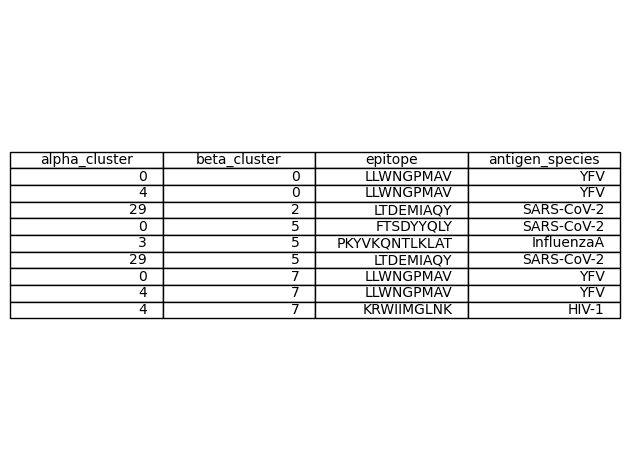

In [28]:
plotting_cooccurence_df = plot_cooccured_epitopes_table(res_alpha, res_beta, cooccurence_dist1_epitopes, vdjdb)

# plotting fig2

In [41]:
def plot_logo(clones, ax):
    logomaker.Logo(logomaker.alignment_to_matrix(list(clones)), color_scheme='skylign_protein', ax=ax)

In [29]:
desc = prepare_run_column(desc)

(array([2694., 2912., 1166.,  487.,  346.,  187.,  113.,   96.,   56.,
         144.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

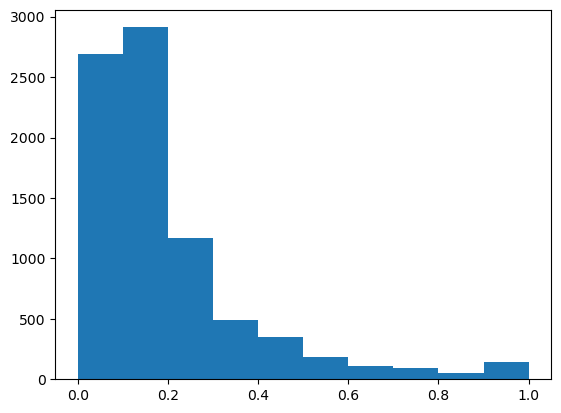

In [30]:
plt.hist(cooccurence_df.to_numpy().flatten())

updated version
0.027618388243509498 241.47256621167105 0.6652443032549012 2.7258100273257892e-09 0.003968763456753542
0.06021198871889421 57.89065237950399 0.6638946067712783 5.996552707092419e-08 0.009497283247338931
updated version
0.0651611635288539 257.50557128143714 0.7598841377306761 5.15154381775757e-13 0.007137218590762686
0.11061392436525584 -286.80042819196296 0.9174181516994124 4.696417497124338e-22 0.0067182800041922465
YLDAYNMMI
IPVAYRKVL
PTDNYITTY
35


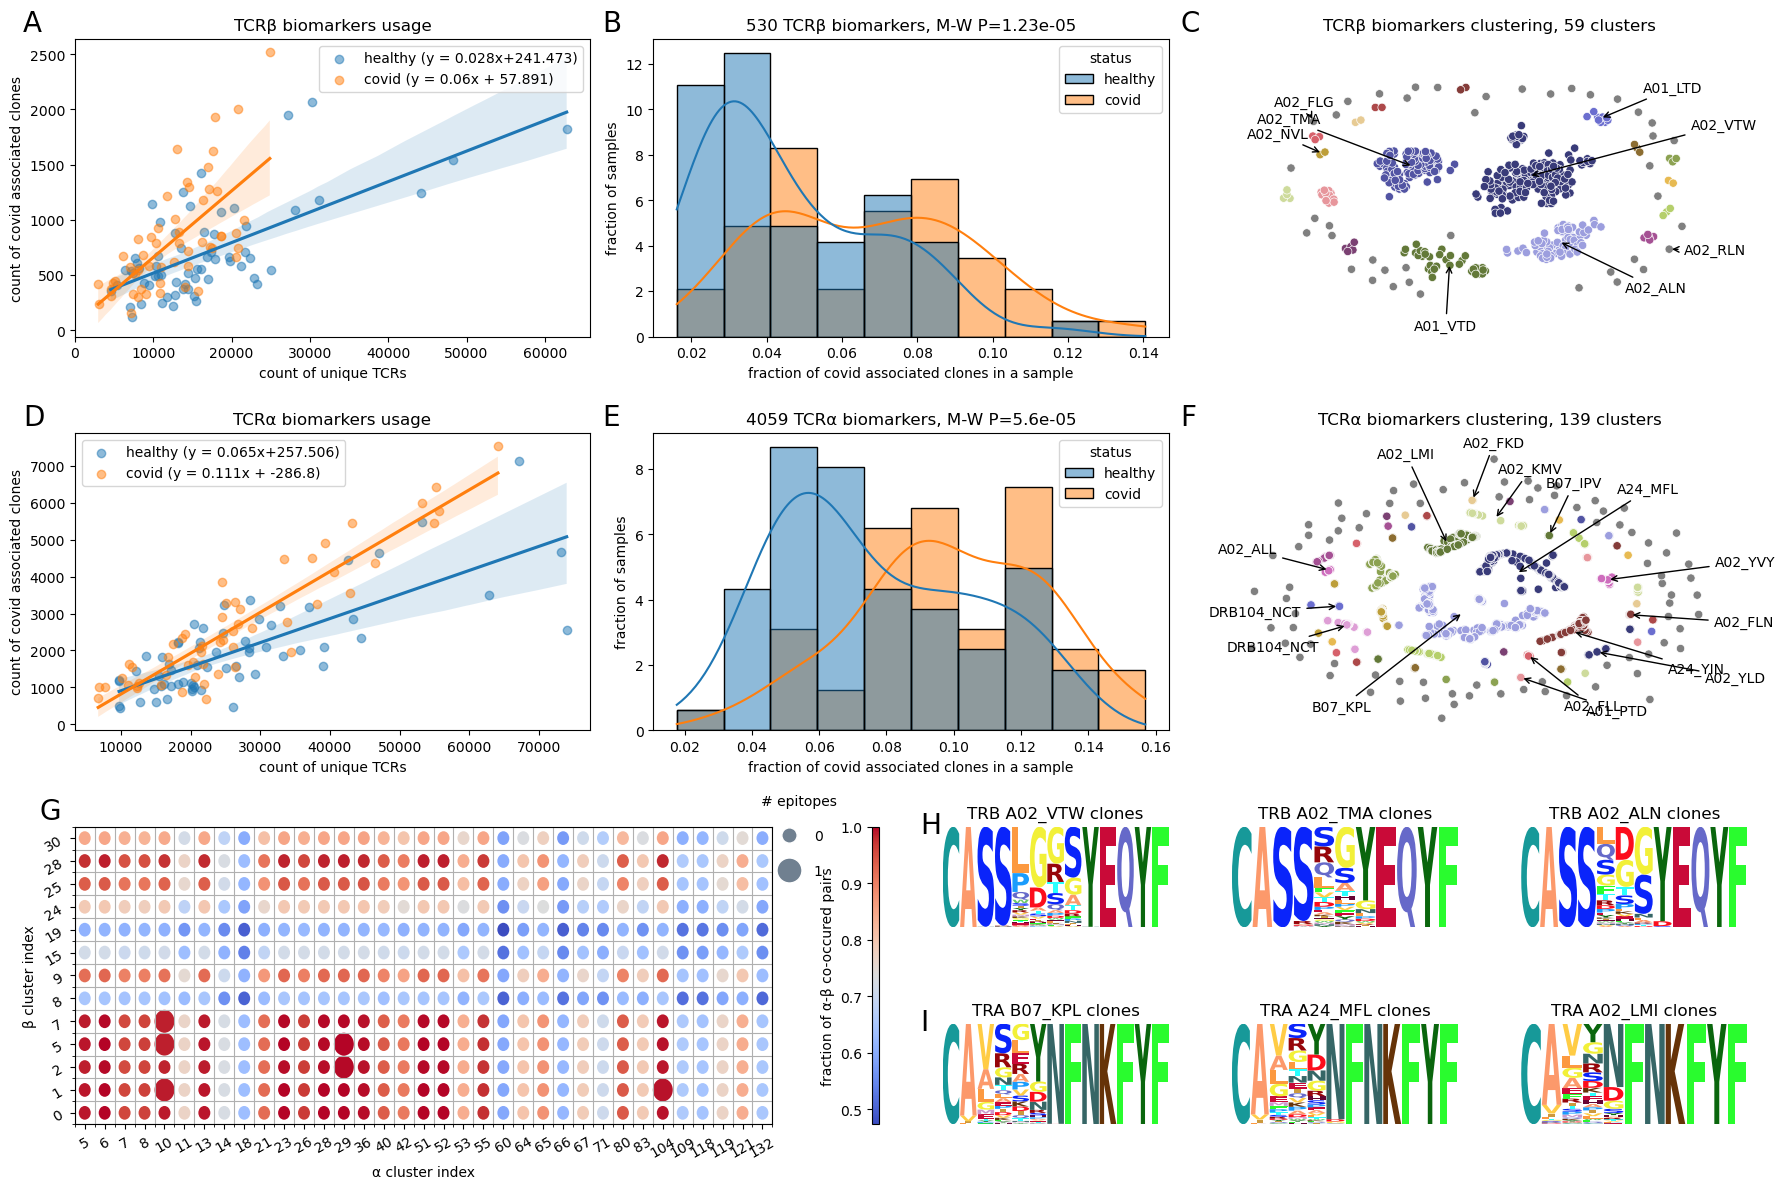

In [95]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
time = np.linspace(0, 10, 1000)
height = np.sin(time)
weight = time*0.3 + 2
score = time**2 + height
distribution = np.random.normal(0, 1, len(time))
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(nrows=12, 
              ncols=6)
font_size=20
delta_x=-0.1
delta_y=1.1

ax0 = fig.add_subplot(gs[:4, :2])
ax1 = fig.add_subplot(gs[:4, 2:4])
ax5 = fig.add_subplot(gs[:4, 4:])
significant_clones_distribution(significant_clonotype_matrix=prepare_run_column(clean_beta_cm[clean_beta_cm.run.isin(test_runs)]), 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'), 
                                desc=desc, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                reg_ax=ax0, 
                                hist_ax=ax1)
ax0.set_title('TCRβ biomarkers usage')
ax0.legend()
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)

beta_cluster_to_epi_abbr = plot_clonotype_clustering_with_epitope_labeling(res_beta, beta_cluster_to_epi, vdjdb, gene='TRB', dist_to_center=700, global_zero_based=True, ax=ax5)
ax5.set_xlim(-800, 800)
ax5.set_ylim(-800, 800)
ax5.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.axis('off')
ax5.legend().remove()
ax5.set_title(f'TCRβ biomarkers clustering, {res_beta.cluster.max() + 1} clusters')

####################################################

ax2 = fig.add_subplot(gs[4:8, :2])
ax3 = fig.add_subplot(gs[4:8, 2:4])
ax6 = fig.add_subplot(gs[4:8, 4:])
significant_clones_distribution(significant_clonotype_matrix=prepare_run_column(clean_alpha_cm[clean_alpha_cm.run.isin(test_runs)]), 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'), 
                                desc=desc, 
                                data_description='TCRα biomarkers',
                                by='covid',
                                reg_ax=ax2, 
                                hist_ax=ax3)
ax2.set_title(f'TCRα biomarkers usage')
ax2.legend()
ax2.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)

ax3.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

alpha_cluster_to_epi_abbr = plot_clonotype_clustering_with_epitope_labeling(res_alpha, 
                                                alpha_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRA', 
                                                cluster_size_threshold=0, 
                                                dist_to_center=450, 
                                                center_diff_threshold=75,
                                                ax=ax6)
ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)
ax6.axis('off')
ax6.set_xlim(-500, 500)
ax6.set_ylim(-500, 600)
ax6.legend().remove()
ax6.set_title(f'TCRα biomarkers clustering, {res_alpha.cluster.max() + 1} clusters')
###################################################

ax7 = fig.add_subplot(gs[8:, :3])
plot_cooccurence_heatmap_with_epitopes_labeling_bubble(cooccurence_df, annot_df, fig=fig, ax=ax7, 
       corr_threshold_row=np.quantile(cooccurence_df.to_numpy().flatten(), 0.95), 
       corr_threshold_col=np.quantile(cooccurence_df.to_numpy().flatten(), 0.95), 
       epitopes_count_threshold=0,  legend_x=1.11)
ax7.text(delta_x+0.05, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)

###################################################

i, j = 0, 0 
while i < 3:
    if beta_clusters_list[j] in beta_cluster_to_epi_abbr:
        cluster_idx = beta_clusters_list[j]
        i += 1
        ax = fig.add_subplot(gs[8:10, j + 3])
        epi = beta_cluster_to_epi_abbr[cluster_idx]
        plot_logo(res_beta[res_beta.cluster == cluster_idx].cdr3, ax)
        ax.set_title(f'TRB {epi} clones')
        ax.axis('off')
        if i == 1:
            ax.text(delta_x, delta_y+0.05, 'H',
                     horizontalalignment='left',
                     verticalalignment='top',
                     transform=ax.transAxes,
                     size=font_size)
    j += 1

###################################################

i, j = 0, 0 
while i < 3:
    if alpha_clusters_list[j] in alpha_cluster_to_epi_abbr:
        cluster_idx = alpha_clusters_list[j]
        i += 1
        ax = fig.add_subplot(gs[10:, j + 3])
        epi = alpha_cluster_to_epi_abbr[cluster_idx]
        plot_logo(res_alpha[res_alpha.cluster == cluster_idx].cdr3, ax)
        ax.set_title(f'TRA {epi} clones')
        ax.axis('off')
        if i == 1:
            ax.text(delta_x, delta_y+0.05, 'I',
                     horizontalalignment='left',
                     verticalalignment='top',
                     transform=ax.transAxes,
                     size=font_size)
    j += 1

###################################################
plt.tight_layout()
plt.savefig("figures/fig2.svg")
plt.savefig("figures/fig2.pdf")
plt.savefig("figures/fig2.png")
plt.show()

Figure 2. FMBA data TCRα and TCRβ biomarkers analysis.

A, D. Scatterplots comparing the distribution of the number of COVID-associated TCRβs/TCRαs to the total number of unique TCRβs/TCRαs sampled for COVID-19 patients and healthy donors.

B, E. Distribution of the number of COVID-associated TCRβs/TCRαs showing the significant difference in COVID-19 patients/ healthy donors.

C, F. Vizualization of COVID-associated TCRβs/TCRαs based on hamming distance. The closer the points are the less the hamming distance between the CDRs is.

G. Coouccurence of CDRs in α/β clusters. Coouccurence was calculated as the percent of TCRα/TCRβ pairs which are found together in more than 80% of samples which contain either the described TCRα, or TCRβ biomarker. The number in each cell of the matrix corresponds to the number of epitopes from VDJdb, which are found to be associated with both TCRα and TCRβ clusters.

# plotting supp fig 1

In [32]:
df = fold_change_data_alpha[(fold_change_data_alpha['log_fold_change'] != np.inf) & (fold_change_data_alpha['log_fold_change'] > 1)]
df['logp'] = np.log10(df.pval)

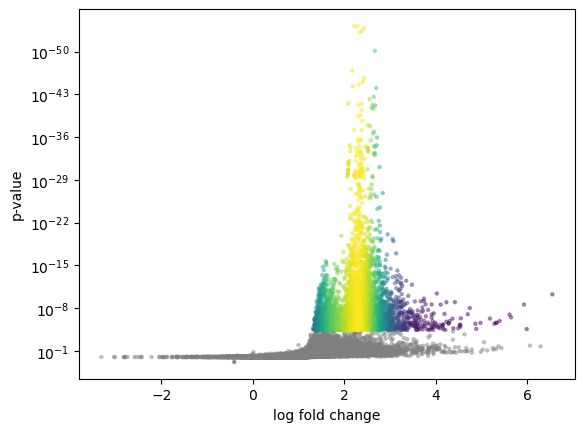

In [33]:
plot_volcano(fold_change_data_alpha, selected_clones=clean_alpha_cm.columns)

In [34]:
raw_beta_cm = prepare_run_column(raw_beta_cm)
raw_alpha_cm = prepare_run_column(raw_alpha_cm)

updated version
0.029345883528249846 245.12611224839225 0.6751187907267566 3.181192217248675e-32 0.00211440500061904
0.035720852098951816 318.04223688977515 0.6413337549645418 9.512801521559375e-72 0.0017359815419544624
updated version
0.07769328278088534 731.0365713533781 0.5836077175634989 1.4230272760284955e-22 0.007128098105389259
0.11892277107656872 957.9459429909775 0.8105550034498707 6.247601343781995e-143 0.0034905482732536406


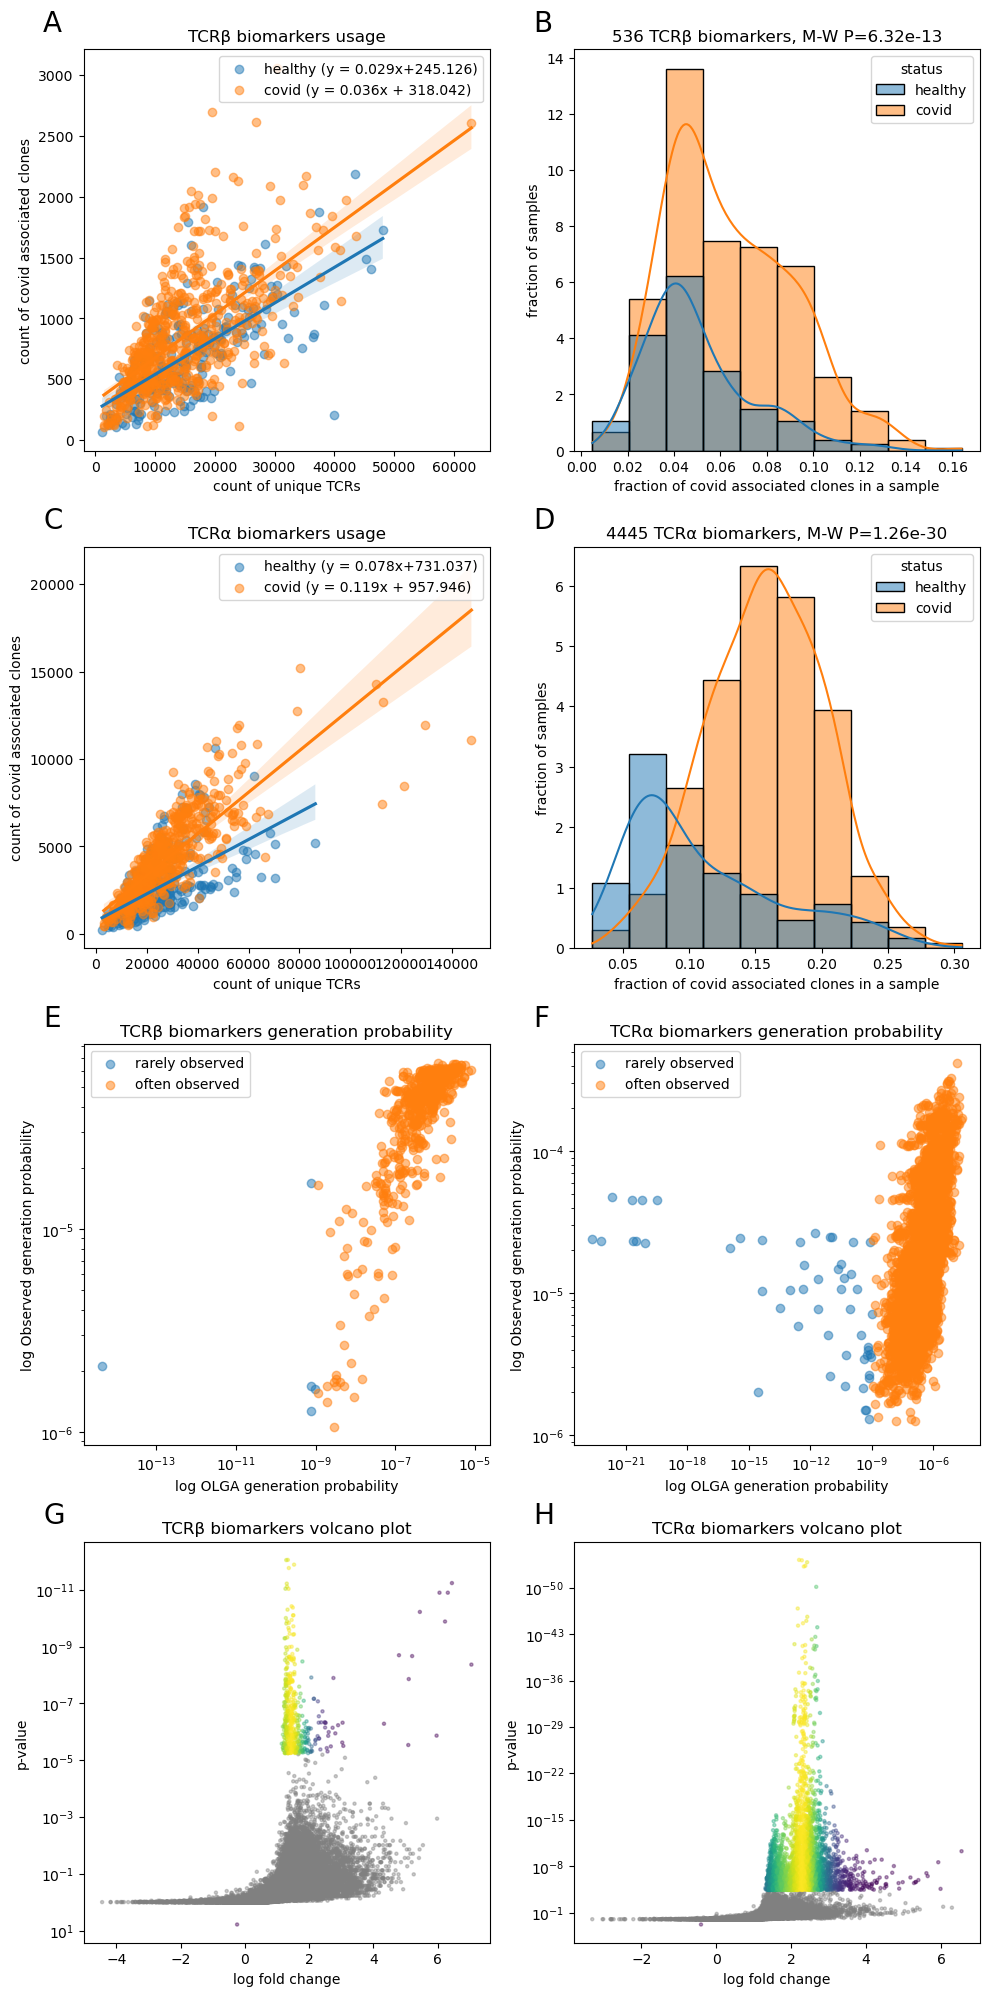

In [35]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(10, 20))
gs = GridSpec(nrows=4, 
              ncols=2)
font_size=20
delta_x=-0.1
delta_y=1.1

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
significant_clones_distribution(significant_clonotype_matrix=raw_beta_cm[raw_beta_cm.run.isin(train_runs)], 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'), 
                                desc=desc, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                reg_ax=ax0, 
                                hist_ax=ax1)
ax0.set_title('TCRβ biomarkers usage')
ax0.legend()
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

# ax1.set_title('TCRβ biomarkers histogram')
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)

ax4 = fig.add_subplot(gs[2, 0])
plot_olga_cleanup_data(probas_beta, observed_threshold=1e-6, gen_threshold=1e-9, ax=ax4)
ax4.set_title('TCRβ biomarkers generation probability')
ax4.legend()
ax4.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)

####################################################

ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
significant_clones_distribution(significant_clonotype_matrix=raw_alpha_cm[raw_alpha_cm.run.isin(train_runs)], 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'), 
                                desc=desc, 
                                data_description='TCRα biomarkers',
                                by='covid',
                                reg_ax=ax2, 
                                hist_ax=ax3)
ax2.set_title('TCRα biomarkers usage')
ax2.legend()
ax2.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)

# ax3.set_title('α biomarkers histogram')
ax3.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)


ax5 = fig.add_subplot(gs[2, 1])
plot_olga_cleanup_data(probas_alpha, observed_threshold=1e-6, gen_threshold=1e-9, ax=ax5)
ax5.set_title('TCRα biomarkers generation probability')
ax5.legend()
ax5.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)

###################################################
ax6 = fig.add_subplot(gs[3, 1])

plot_volcano(fold_change_data_alpha, selected_clones=clean_alpha_cm.columns, ax=ax6)
ax6.set_title('TCRα biomarkers volcano plot')
ax6.text(delta_x, delta_y, 'H',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)

###################################################
ax7 = fig.add_subplot(gs[3, 0])

plot_volcano(fold_change_data_beta, selected_clones=clean_beta_cm.columns, ax=ax7)
ax7.set_title('TCRβ biomarkers volcano plot')
ax7.text(delta_x, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)

###################################################

plt.tight_layout()
plt.savefig("figures/supp_fig1.svg")
plt.savefig("figures/supp_fig1.pdf")
plt.savefig("figures/supp_fig1.png")
plt.show()

# Making up summary table for selected clones

In [36]:
def get_most_frequent_cluster_by_vdjdb_occurence(vdjdb, cluster_epitopes, gene='TRB'):
    cluster_epitopes['cluster_epitopes_freq'] = cluster_epitopes.apply(lambda x: x['count'] / vdjdb[
        (vdjdb.gene == gene) & (vdjdb['antigen.epitope'] == x['antigen.epitope'])].cdr3.nunique(), axis=1)
    cluster_epitopes = cluster_epitopes.merge(vdjdb[['antigen.epitope', 'mhc.a']])
    return cluster_epitopes.sort_values(by='cluster_epitopes_freq', ascending=False).reset_index(drop=True).loc[0, :]

def get_most_probable_antigen(x, cluster_to_epi):
    if cluster_to_epi[x] is None or len(cluster_to_epi[x]) == 0:
        return '-', '-', 0, '-'
    df = cluster_to_epi[x]
    df = df[~df['antigen.species'].str.contains('apiens')]
    if len(df) == 0:
        return '-', '-', 0, '-'
    res = get_most_frequent_cluster_by_vdjdb_occurence(
        vdjdb, 
        df,
        gene='TRB')
    return res[['antigen.epitope', 'antigen.species', 'count', 'mhc.a']]


def create_summary_stats_table(clustering_res, cluster_to_epi, cm, vdjdb, desc, gene='TRB'):
    summary = clustering_res[['cluster', 'cluster_size']].drop_duplicates()
    summary['antigen.epitope'] = summary.cluster.apply(lambda x:  get_most_probable_antigen(x, cluster_to_epi)[0])
    summary['antigen.species'] = summary.cluster.apply(lambda x:  get_most_probable_antigen(x, cluster_to_epi)[1])
    summary['num_epi_associated_clones'] = summary.cluster.apply(lambda x: get_most_probable_antigen(x, cluster_to_epi)[2])
    summary['mhc_a'] = summary.cluster.apply(lambda x: get_most_probable_antigen(x, cluster_to_epi)[3])
    summary['mhc_a'] = summary['mhc_a'].apply(lambda x: x.split(':')[0].split('-')[1])
    summary['fraction_epi_associated_clones'] = summary['num_epi_associated_clones'] / summary['cluster_size']

    train_runs = desc[~desc.is_test_run].run
    test_runs = desc[desc.is_test_run].run

    healthy_train_cm = cm[cm.run.isin(train_runs)].merge(desc[['run']][desc.COVID_status == 'healthy'])
    healthy_test_cm = cm[cm.run.isin(test_runs)].merge(desc[['run']][desc.COVID_status == 'healthy'])
    covid_train_cm = cm[cm.run.isin(train_runs)].merge(desc[['run']][desc.COVID_status != 'healthy'])
    covid_test_cm = cm[cm.run.isin(test_runs)].merge(desc[['run']][desc.COVID_status != 'healthy'])

    train_cm = cm[cm.run.isin(train_runs)]
    test_cm = cm[cm.run.isin(test_runs)]
    summary['num_samples_with_cluster_train'] = summary.cluster.apply(
        lambda x: (train_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_train_healthy'] = summary.cluster.apply(
        lambda x: (healthy_train_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_train_covid'] = summary.cluster.apply(
        lambda x: (covid_train_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())

    summary['num_samples_with_cluster_test'] = summary.cluster.apply(
        lambda x: (test_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_test_healthy'] = summary.cluster.apply(
        lambda x: (healthy_test_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_test_covid'] = summary.cluster.apply(
        lambda x: (covid_test_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    
    summary['fraction_samples_with_cluster_train'] = summary['num_samples_with_cluster_train'] / len(train_cm)
    summary['fraction_of_healthy_samples_in_cluster_train'] = summary['num_samples_with_cluster_train_healthy'] / summary['num_samples_with_cluster_train']
    summary['fraction_of_covid_samples_in_cluster_train'] = summary['num_samples_with_cluster_train_covid'] / summary['num_samples_with_cluster_train']
    
    summary['fraction_samples_with_cluster_test'] = summary['num_samples_with_cluster_test'] / len(test_cm)
    summary['fraction_of_healthy_samples_in_cluster_test'] = summary['num_samples_with_cluster_test_healthy'] / summary['num_samples_with_cluster_test']
    summary['fraction_of_covid_samples_in_cluster_test'] = summary['num_samples_with_cluster_test_covid'] / summary['num_samples_with_cluster_test']
    
    # summary.to_excel(f'figures/clustering_summary_{gene}.xlsx')
    summary.to_csv(f'figures/clustering_summary_{gene}.csv', index=False)
    return summary

In [37]:
beta_summary = create_summary_stats_table(res_beta, beta_cluster_to_epi, clean_beta_cm, vdjdb, desc=desc, gene='TRB')
beta_summary

,cluster,cluster_size,antigen.epitope,antigen.species,num_epi_associated_clones,mhc_a,fraction_epi_associated_clones,num_samples_with_cluster_train,num_samples_with_cluster_train_healthy,num_samples_with_cluster_train_covid,num_samples_with_cluster_test,num_samples_with_cluster_test_healthy,num_samples_with_cluster_test_covid,fraction_samples_with_cluster_train,fraction_of_healthy_samples_in_cluster_train,fraction_of_covid_samples_in_cluster_train,fraction_samples_with_cluster_test,fraction_of_healthy_samples_in_cluster_test,fraction_of_covid_samples_in_cluster_test
0,0,182,VTWFHAIHV,SARS-CoV-2,4,A*02,0.021978,840,232,608,116,63,53,1.000000,0.276190,0.723810,1.000000,0.543103,0.456897
182,1,127,TMADLVYAL,SARS-CoV-2,17,A*02,0.133858,840,232,608,116,63,53,1.000000,0.276190,0.723810,1.000000,0.543103,0.456897
309,2,10,LTDEMIAQY,SARS-CoV-2,10,A*01,1.000000,837,231,606,116,63,53,0.996429,0.275986,0.724014,1.000000,0.543103,0.456897
319,3,1,-,-,0,,0.000000,141,17,124,12,6,6,0.167857,0.120567,0.879433,0.103448,0.500000,0.500000
320,4,1,-,-,0,,0.000000,294,64,230,23,14,9,0.350000,0.217687,0.782313,0.198276,0.608696,0.391304
321,5,82,ALNTPKDHI,SARS-CoV-2,12,A*02,0.146341,839,231,608,116,63,53,0.998810,0.275328,0.724672,1.000000,0.543103,0.456897
403,6,1,-,-,0,,0.000000,382,94,288,51,25,26,0.454762,0.246073,0.753927,0.439655,0.490196,0.509804
404,7,40,VTDVTQLYL,SARS-CoV-2,10,A*01,0.250000,838,231,607,116,63,53,0.997619,0.275656,0.724344,1.000000,0.543103,0.456897
444,8,3,-,-,0,,0.000000,537,132,405,81,39,42,0.639286,0.245810,0.754190,0.698276,0.481481,0.518519
447,9,3,-,-,0,,0.000000,780,215,565,106,58,48,0.928571,0.275641,0.724359,0.913793,0.547170,0.452830


In [38]:
alpha_summary = create_summary_stats_table(res_alpha, alpha_cluster_to_epi, clean_alpha_cm, vdjdb, desc=desc, gene='TRA')
alpha_summary

,cluster,cluster_size,antigen.epitope,antigen.species,num_epi_associated_clones,mhc_a,fraction_epi_associated_clones,num_samples_with_cluster_train,num_samples_with_cluster_train_healthy,num_samples_with_cluster_train_covid,num_samples_with_cluster_test,num_samples_with_cluster_test_healthy,num_samples_with_cluster_test_covid,fraction_samples_with_cluster_train,fraction_of_healthy_samples_in_cluster_train,fraction_of_covid_samples_in_cluster_train,fraction_samples_with_cluster_test,fraction_of_healthy_samples_in_cluster_test,fraction_of_covid_samples_in_cluster_test
0,0,793,MFLARGIVF,SARS-CoV-2,27,A*24,0.034048,320,56,264,8,4,4,0.380952,0.175000,0.825000,0.068966,0.500000,0.500000
793,1,92,LPRWYFYYL,HCoV-HKU1,32,B*07,0.347826,384,83,301,21,11,10,0.457143,0.216146,0.783854,0.181034,0.523810,0.476190
885,2,5,-,-,0,,0.000000,382,78,304,53,26,27,0.454762,0.204188,0.795812,0.456897,0.490566,0.509434
890,3,1078,KPLPEVKIL,SARS-CoV-2,16,B*07,0.014842,322,61,261,8,4,4,0.383333,0.189441,0.810559,0.068966,0.500000,0.500000
1968,4,384,LMIERFVSL,SARS-CoV-2,20,A*02,0.052083,325,56,269,11,6,5,0.386905,0.172308,0.827692,0.094828,0.545455,0.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4044,134,10,PTDNYITTY,SARS-CoV-2,10,A*01,1.000000,428,96,332,56,31,25,0.509524,0.224299,0.775701,0.482759,0.553571,0.446429
4054,135,1,-,-,0,,0.000000,63,6,57,2,0,2,0.075000,0.095238,0.904762,0.017241,0.000000,1.000000
4055,136,2,-,-,0,,0.000000,214,34,180,25,11,14,0.254762,0.158879,0.841121,0.215517,0.440000,0.560000
4057,137,1,-,-,0,,0.000000,157,23,134,23,11,12,0.186905,0.146497,0.853503,0.198276,0.478261,0.521739


In [39]:
beta_summary[beta_summary['antigen.epitope'] != '-']

,cluster,cluster_size,antigen.epitope,antigen.species,num_epi_associated_clones,mhc_a,fraction_epi_associated_clones,num_samples_with_cluster_train,num_samples_with_cluster_train_healthy,num_samples_with_cluster_train_covid,num_samples_with_cluster_test,num_samples_with_cluster_test_healthy,num_samples_with_cluster_test_covid,fraction_samples_with_cluster_train,fraction_of_healthy_samples_in_cluster_train,fraction_of_covid_samples_in_cluster_train,fraction_samples_with_cluster_test,fraction_of_healthy_samples_in_cluster_test,fraction_of_covid_samples_in_cluster_test
0,0,182,VTWFHAIHV,SARS-CoV-2,4,A*02,0.021978,840,232,608,116,63,53,1.000000,0.276190,0.723810,1.000000,0.543103,0.456897
182,1,127,TMADLVYAL,SARS-CoV-2,17,A*02,0.133858,840,232,608,116,63,53,1.000000,0.276190,0.723810,1.000000,0.543103,0.456897
309,2,10,LTDEMIAQY,SARS-CoV-2,10,A*01,1.000000,837,231,606,116,63,53,0.996429,0.275986,0.724014,1.000000,0.543103,0.456897
321,5,82,ALNTPKDHI,SARS-CoV-2,12,A*02,0.146341,839,231,608,116,63,53,0.998810,0.275328,0.724672,1.000000,0.543103,0.456897
404,7,40,VTDVTQLYL,SARS-CoV-2,10,A*01,0.250000,838,231,607,116,63,53,0.997619,0.275656,0.724344,1.000000,0.543103,0.456897
466,21,1,RLNEVAKNL,SARS-CoV-2,1,A*02,1.000000,141,23,118,14,8,6,0.167857,0.163121,0.836879,0.120690,0.571429,0.428571
467,22,1,FLGIITTVA,SARS-CoV-2,1,A*02,1.000000,143,22,121,11,7,4,0.170238,0.153846,0.846154,0.094828,0.636364,0.363636
470,25,2,NVLTLVYKV,SARS-CoV-2,2,A*02,1.000000,790,216,574,109,59,50,0.940476,0.273418,0.726582,0.939655,0.541284,0.458716


In [40]:
alpha_summary[alpha_summary['antigen.epitope'] != '-']

,cluster,cluster_size,antigen.epitope,antigen.species,num_epi_associated_clones,mhc_a,fraction_epi_associated_clones,num_samples_with_cluster_train,num_samples_with_cluster_train_healthy,num_samples_with_cluster_train_covid,num_samples_with_cluster_test,num_samples_with_cluster_test_healthy,num_samples_with_cluster_test_covid,fraction_samples_with_cluster_train,fraction_of_healthy_samples_in_cluster_train,fraction_of_covid_samples_in_cluster_train,fraction_samples_with_cluster_test,fraction_of_healthy_samples_in_cluster_test,fraction_of_covid_samples_in_cluster_test
0,0,793,MFLARGIVF,SARS-CoV-2,27,A*24,0.034048,320,56,264,8,4,4,0.380952,0.175000,0.825000,0.068966,0.500000,0.500000
793,1,92,LPRWYFYYL,HCoV-HKU1,32,B*07,0.347826,384,83,301,21,11,10,0.457143,0.216146,0.783854,0.181034,0.523810,0.476190
890,3,1078,KPLPEVKIL,SARS-CoV-2,16,B*07,0.014842,322,61,261,8,4,4,0.383333,0.189441,0.810559,0.068966,0.500000,0.500000
1968,4,384,LMIERFVSL,SARS-CoV-2,20,A*02,0.052083,325,56,269,11,6,5,0.386905,0.172308,0.827692,0.094828,0.545455,0.454545
2352,5,299,QVPLRPMTYK,HIV-1,13,A*03,0.043478,831,229,602,116,63,53,0.989286,0.275572,0.724428,1.000000,0.543103,0.456897
2822,10,155,APFSEQEQPVLG,TriticumAestivum,21,DQA1*02,0.135484,830,230,600,115,62,53,0.988095,0.277108,0.722892,0.991379,0.539130,0.460870
2980,13,10,FKDNVILLN,SARS-CoV-2,6,A*02,0.600000,833,228,605,115,62,53,0.991667,0.273709,0.726291,0.991379,0.539130,0.460870
2991,15,226,YINVFAFPF,SARS-CoV-2,13,A*24,0.057522,297,54,243,3,1,2,0.353571,0.181818,0.818182,0.025862,0.333333,0.666667
3225,21,43,FLLNKEMYL,SARS-CoV-2,11,A*02,0.255814,772,205,567,108,57,51,0.919048,0.265544,0.734456,0.931034,0.527778,0.472222
3347,28,80,YVYSRVKNL,SARS-CoV-2,21,A*02,0.262500,839,231,608,116,63,53,0.998810,0.275328,0.724672,1.000000,0.543103,0.456897
